# Clinical Data Exploration

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from collections import Counter

RANDOM_STATE = 1704

clinical_mr = pd.read_csv("../data/interim/clinical-mri.csv")
print(f"Read {len(clinical_mr)} clinical entries")
print(f"Among the entries there are {len(clinical_mr[clinical_mr.MR_ID.notna()])} MR sessions available")

Read 6224 clinical entries
Among the entries there are 2224 MR sessions available


## Analyzing the rule based labeling
To avoid unexpected failure in a regular expression approach, since the set of different diagnosis is relatively small we assign to each diagnosis the corresponding label, 1 if is an AD diagnosis, 0 otherwise

In [10]:
#first remove ':' character from diagnosis
diag_cols = ["dx1","dx2","dx3","dx4","dx5"]
#for i in diag_cols:
    #clinical_mr[i] = clinical_mr[i].str.replace(':',"")

ad_diags = [
    'AD dem w/oth unusual feat/subs demt','AD dem distrubed social- with','AD dem w/depresss  contribut',
    'AD dem w/CVD contribut','AD dem w/Frontal lobe/demt at onset','AD Dementia','AD dem w/depresss- contribut',
    'AD dem Language dysf with','AD dem w/oth (list B) contribut','AD dem distrubed social  with','AD dem distrubed social- after',
    'DAT','DAT w/depresss not contribut', # Dementia Alzheimer Type
    'AD dem visuospatial  with','AD dem visuospatial, after', 'AD dem visuospatial- prior',
    'AD dem w/CVD not contrib','Active Alcoholism',
    'AD dem distrubed social- prior','AD dem w/depresss, not contribut','AD dem visuospatial- with',
    'AD dem w/depresss- not contribut','AD dem w/oth (list B) not contrib',
    'AD dem w/oth unusual features','AD dem w/depresss  not contribut',
    'AD dem visuospatial- after','AD dem Language dysf after',
    'AD dem w/PDI after AD dem contribut','AD dem cannot be primary','AD dem/FLD prior to AD dem',
    'AD dem Language dysf prior','AD dem w/PDI after AD dem not contrib','AD dem w/oth unusual features/demt on',
    '0.5 in memory only','uncertain dementia','other mental retarAD demion',]


TypeError: unsupported operand type(s) for |: 'dict' and 'zip'

In [ ]:

non_ad = [
    'Active B-12 Deficiency','Non AD dem- Other primary','Remote PD drug-induced','Remote CVD',
    'Remote Alcoholism','Park Idiopathic','Active Bereavement','Vascular Demt- primary',
    'Frontotemporal demt. secn','Incipient demt PTP','Remote Med-induced Cog Dys',
    'Remote Other neurol/med diagnoses','ProAph w/o dement','Remote Amnestic syndrome',
    'Active Major Head Trauma','Active Affective disorder','Dementia/PD- primary','Active CVD',
    'other neurol/med diagnoses','Active Seizure Disorder','DLBD- primary','Non AD dem- Other secondary',
    'Active DLBD','Active Mood disorder','Remote Mood disorder','Remote Seizure Disorder','Cognitively normal',
    'Vascular Demt- secondary','Remote B-12 Deficiency','Remote Global Cerebral Hypop','Rapid Course (not CJD)',
    'Remote Bereavement','Remote PD idiopathic','Oth potentially transmissible dis','Active PSNP','DLBD, primary',
    'DLBD- secondary','Active Med-induced Cog Dys','No dementia','Remote Hypothyroidism','Active PD idiopathic',
    'Active Hydrocephalus','Frontotemporal demt. prim','DLBD  secondary','Remote Major Head Trauma',
    'Active Hypothyroidism', 'Incipient Non-AD dem','Active PD drug-induced','Remote Hydrocephalus',
    'Vascular Demt  primary','Active Global Cerebral Hypop','.']


In [ ]:

uncertain = ['Unc: ques. Impairment','Unc: impair reversible',
             'Active Other neurol/med diagnoses',
             'uncertain  possible NON AD dem','uncertain- possible NON AD dem',]


In [ ]:

#Convert the lists into a dict to allow fast mapping
diag_map = dict(zip(ad_diags, [True for _ in ad_diags]))
diag_map.update(dict(zip(non_ad, [False for _ in non_ad])))

uncertain_as = False #how to deal with uncertain diagnosis
diag_map.update(dict(zip(uncertain, [uncertain_as for _ in uncertain])))
diag_map

[Text(0, 0, '4745'), Text(0, 0, '1479')]

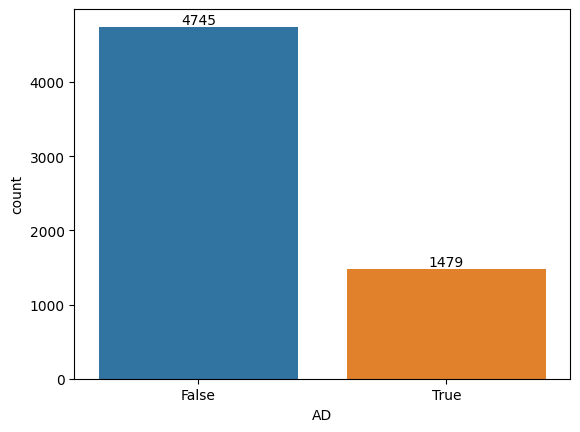

In [9]:
clinical_mr["AD"] = clinical_mr.apply(lambda x: any(diag_map[x[c]] for c in diag_cols), axis=1)

ax = sns.countplot(data = clinical_mr, x="AD")
ax.bar_label(ax.containers[0])

In [11]:


false_neg = [False, False, False, False, False, False, False, True, False, True, False, True, False, False, True, True]
false_pos = [False, False, False, True, False]
strange = [False,False,False,True,True, False, True, False,False,False,False,False, True]

def normalize(diagnosis):
    normalized = np.copy(diagnosis)
    for i in range(len(diagnosis)-1):
        if diagnosis[i]:
            window = diagnosis[i:]
            majority = Counter(window)
            vote = majority[True] > majority[False]
            normalized[i:len(diagnosis)] = np.full((len(diagnosis)-i),vote)

    return list(normalized)

assert (len(false_neg) == len(normalize(false_neg)))
print(normalize(false_neg))
print(normalize(false_pos))
print(normalize(strange))

[False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True]
[False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False]


Subjects normalized: 169


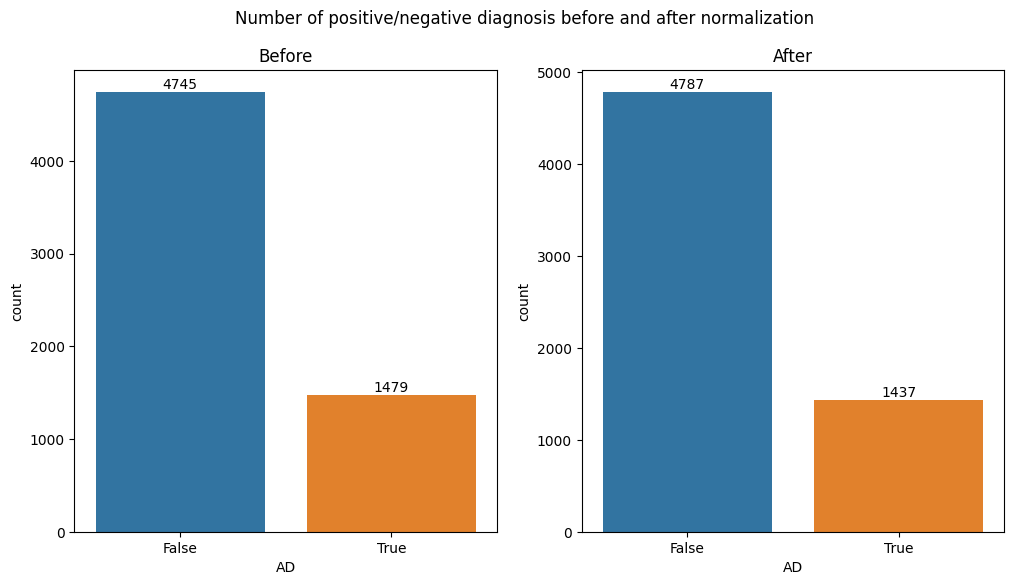

In [5]:
clinical_mr_old = clinical_mr.copy()
subjects = clinical_mr.groupby("Subject")
normalized_subjects = set()

for k in subjects.groups.keys():
    subject = subjects.get_group(k)
    diagnosis = subject["AD"].to_list()
    indexes = list(subject.index)
    normalized = normalize(diagnosis)
    if diagnosis != normalized:
        normalized_subjects.add(k)
        for i in range(len(indexes)):
            clinical_mr.loc[indexes[i],"AD"] = normalized[i]

print(f"Subjects normalized: {len(normalized_subjects)}")

img, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.countplot(data=clinical_mr_old, x="AD", ax=ax1)
sns.countplot(data=clinical_mr, x="AD", ax=ax2)
img.suptitle("Number of positive/negative diagnosis before and after normalization")
ax1.set_title("Before")
ax2.set_title("After")
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])

img.figure.savefig("../reports/figures/diagnosis_dist_comparison.png", bbox_inches='tight', dpi=300)

Normalize the AD diagnosis using a majority vote strategy so that the negative diagnosis after a positive one become positive if the number of subsequents positive is strictly greater than the negative

/var/folders/r5/7br76ph52bd61jg9yfqjy_8c0000gn/T/ipykernel_39193/712713734.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x, y=y, ax= subfig,marker='o', palette='pastel')
/var/folders/r5/7br76ph52bd61jg9yfqjy_8c0000gn/T/ipykernel_39193/712713734.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x, y=y, ax= subfig,marker='o', palette='pastel')
/var/folders/r5/7br76ph52bd61jg9yfqjy_8c0000gn/T/ipykernel_39193/712713734.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=x, y=y, ax= subfig,marker='o', palette='pastel')


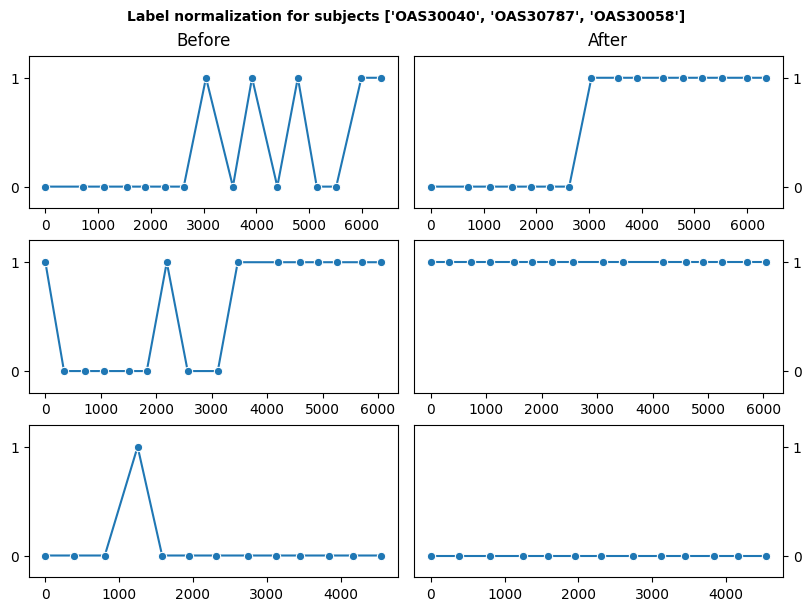

In [6]:
example_subjects = ["OAS30040","OAS30787","OAS30058"]
subjects = clinical_mr.groupby("Subject")
old_subjects = clinical_mr_old.groupby("Subject")

fig = plt.figure(constrained_layout=True, figsize=(8,6))
fig.suptitle(f'Label normalization for subjects {example_subjects}',fontsize=10, fontweight="bold")
subfigs = fig.subfigures(1, 2)

subfigs[0].suptitle("Before")
for row, subfig in enumerate(subfigs[0].subplots(3,1)):
    subfig.set_yticks([0,1])
    subfig.set_ylim([-0.2,1.2])
    old_subject = old_subjects.get_group(example_subjects[row])
    x = old_subject.DaysAfterEntry_clinic.to_list()
    y = old_subject.AD.to_list()
    sns.lineplot(x=x, y=y, ax= subfig, marker='o')

subfigs[1].suptitle("After")
for row, subfig in enumerate(subfigs[1].subplots(3,1)):
    subfig.yaxis.tick_right()
    subfig.set_yticks([0,1])
    subfig.set_ylim([-0.2,1.2])
    subject = subjects.get_group(example_subjects[row])
    x = subject.DaysAfterEntry_clinic.to_list()
    y = subject.AD.to_list()
    style= subject.Subject
    sns.lineplot(x=x, y=y, ax= subfig,marker='o', palette='pastel')

fig.savefig("../reports/figures/example_label_normalization.png",transparent=True, dpi=300, bbox_inches='tight')